# The quantized tensor train (QTT) fromat and applications to turbulent flow

Storing and handling high-dimensional data can be challenging.
This demonstrates how the dimension may be reduced by representing the data in a tensor format.
We then use the results to reproduce the results of :cite:p:`LarK2017` and improve upon them.

In [1]:
%matplotlib inline
import os
import sys
import torch
import numpy as np
from numpy import pi, sin, size, zeros
from numpy.linalg import norm
import matplotlib as mpl
import matplotlib.pyplot as plt

_torchtt_path = os.path.join(os.getcwd(), "torchTT")
if _torchtt_path not in sys.path:
    sys.path.insert(0, _torchtt_path)
import torchtt

def tt_to_numpy(tt):
    return tt.full().detach().cpu().numpy()

def tt_datasize(tt):
    return sum(int(c.numel()) for c in tt.cores)

# mpl.verbose.level = "debug-annoying"


## Setting

Consider the $1$-dimensional sinusoidal function
\begin{equation}\label{eq:0Dfunction}
    f(x)=3.125\sin(x)\sin(2x)\sin(4x) \qquad\qquad\quad x \in [0,2\pi]
\end{equation}
which we interpolate linearly at $N=2^{d}$ ($d=14$) equidistant nodes
\begin{align}
    x_\ast &\in \mathbb{R}^N & x_\ast[i] &:= \frac{2\pi i}{N-1} \\
    f_\ast &\in \mathbb{R}^N & f_\ast[i] &:= f(x_\ast[i]) %= f\left(\frac{2\pi i}{N-1}\right) \ .
\end{align}

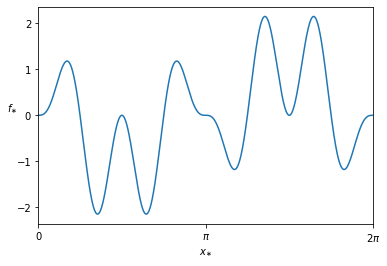

In [2]:
f = lambda x: 3.125 * sin(x) * sin(2*x) * sin(4*x)
domain = (0, 2*pi)

d = 14
N = 2**d
xs = np.linspace(*domain, num=N)
fs = f(xs)

plt.figure()
plt.plot(xs, fs)
plt.xlabel(r"$x_{\ast}$")
plt.ylabel(r"$f_{\ast}$", rotation=None)
plt.xticks([0,pi,2*pi],(r"0",r"$\pi$",r"$2\pi$"))
plt.xlim(*domain);

## Reshapings

Storing $f$ this way results in a storage requirement of $\mathcal{O}(N)$.
In the next two sub-sections we will explore different reshapings of the array $f_\ast$, their interpretation and how they can be used to reduce the storage costs for $f$.

### Reshaping for symmetry

Reshaping the $x_\ast$ and $f_\ast$ arrays as
\begin{align}
x_{2,\ast} &\in \mathbb{R}^{2\times N/2} \\
x_{2,\ast}[i,j] &= x_\ast[i\cdot \tfrac{N}{2} + j]
\end{align}
we observe that $x_{2,\ast}[0]\in\mathbb{R}^{N/2}$ contains the first half of $x_\ast$ and $x_{2,\ast}[1]\in\mathbb{R}^{N/2}$ contains the second half of $x_\ast$.

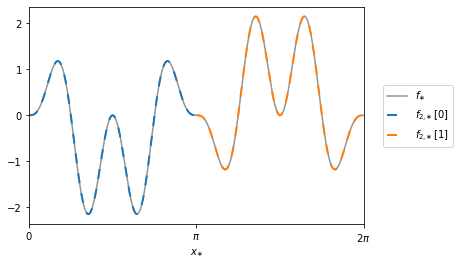

In [9]:
x2s = xs.reshape(2,-1)
f2s = fs.reshape(2,-1)

assert np.all(x2s[0] == xs[:N//2]) and np.all(x2s[1] == xs[N//2:])
assert np.all(f2s[0] == fs[:N//2]) and np.all(f2s[1] == fs[N//2:])

plt.figure()
plt.plot(xs, fs, color="xkcd:gray", label=r"$f_{\ast}$")
for i in range(2):
    plt.plot(x2s[i], f2s[i], color=f"C{i}", linestyle=(0, (5,5)), linewidth=2, label=fr"$f_{{2,\!\!\ast}}[{i}]$")
plt.xlabel(r"$x_{\ast}$")
plt.xticks([0,pi,2*pi],(r"0",r"$\pi$",r"$2\pi$"))
plt.xlim(*domain)
plt.figlegend(loc="center", bbox_to_anchor=(1.025, .5, .0, .0));

Inspecting the graph of $f$ we can observe that $f_{2,\ast}[0] \approx f_{2,\ast}[1]$.

The L2 error of this approximation is 1.72e-03.


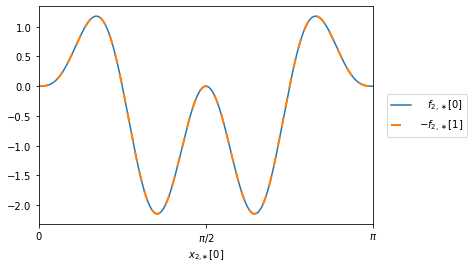

In [10]:
plt.figure()
plt.plot(x2s[0],  f2s[0], color="C0", label=r"$\ \ \,f_{2,\ast}[0]$")
plt.plot(x2s[0], -f2s[1], color="C1", linestyle=(0, (5,5)), linewidth=2, label=r"$-f_{2,\ast}[1]$")
plt.xlabel(r"$x_{2,\!\!\ast}[0]$")
plt.xticks([0,pi/2,pi], [r"0",r"$\pi/2$",r"$\pi$"])
plt.xlim(0, pi)
plt.figlegend(loc="center", bbox_to_anchor=(1.025, .5, .0, .0));

L2norm = lambda y,x: np.sqrt(np.trapz(y**2,x))
error = L2norm(f2s[0]+f2s[1], x2s[0])
print(f"The L2 error of this approximation is {error:.2e}.")

This means that we can approximate
\begin{align}
    f_{2,\ast} \approx \begin{bmatrix} 1 \\ -1 \end{bmatrix} \otimes f_{2,\ast}[0],
\end{align}
which reduces the memory required to store $f_\ast$ from $\mathcal{O}(N)$ to $\mathcal{O}(2 + \frac{N}{2})$.
The error of this approximation is bounded by $1.72\cdot 10^{-3}$ and may even be reduced by optimizing the two factors $\begin{bmatrix}1 & -1\end{bmatrix}^\intercal$ and $f_{2,\ast}[0]$.

In [11]:
f2s_tt = torchtt.TT(torch.tensor(f2s, dtype=torch.float64))
f2s_tt = f2s_tt.round(1)
assert max(f2s_tt.R) == 1
f2s_tt = tt_to_numpy(f2s_tt)
assert f2s_tt.shape == (2, N//2)
error = L2norm(f2s_tt.reshape(N)-fs, xs)
print(f"The optimal L2 error that can be achieved is {error:.2e}.")


The optimal L2 error that can be achieved is 1.22e-03.


This idea works astonishingly well and can also be applied to other symmetries of $f$.
Analogously to $x_{2,\ast}\in\mathbb{R}^{2,N/2}$ we define $x_{4,\ast}\in\mathbb{R}^{4,N/4}$ and observe that
\begin{equation}
    f_{4,\ast}[0] = -f_{4,\ast}[2]
    \qquad\text{and}\qquad
    f_{4,\ast}[1] = -f_{4,\ast}[3] .
\end{equation}

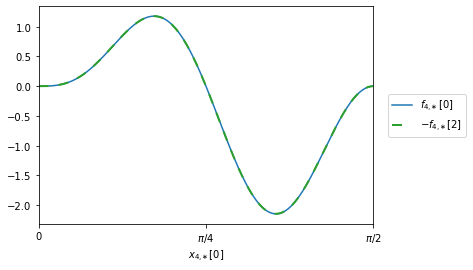

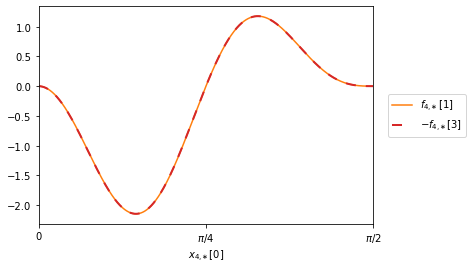

In [12]:
x4s = xs.reshape(4,-1)
f4s = fs.reshape(4,-1)

plt.figure()
plt.plot(x4s[0],  f4s[0], color="C0", label=r"$f_{4,\!\!\ast}[0]$")
plt.plot(x4s[0], -f4s[2], color="C2", linestyle=(0, (5,5)), linewidth=2, label=r"$-f_{4,\!\!\ast}[2]$")
plt.xlabel(r"$x_{4,\!\!\ast}[0]$")
plt.xticks([0,pi/4,pi/2], [r"0",r"$\pi/4$",r"$\pi/2$"])
plt.xlim(0, pi/2)
plt.figlegend(loc="center", bbox_to_anchor=(1.025, .5, .0, .0));

plt.figure()
plt.plot(x4s[0],  f4s[1], color="C1", label=r"$f_{4,\!\!\ast}[1]$")
plt.plot(x4s[0], -f4s[3], color="C3", linestyle=(0, (5,5)), linewidth=2, label=r"$-f_{4,\!\!\ast}[3]$")
plt.xlabel(r"$x_{4,\!\!\ast}[0]$")
plt.xticks([0,pi/4,pi/2], [r"0",r"$\pi/4$",r"$\pi/2$"])
plt.xlim(0, pi/2)
plt.figlegend(loc="center", bbox_to_anchor=(1.025, .5, .0, .0));

The function $f$ can hence be approximated as
\begin{equation}
    f_{4,\ast} \approx \begin{bmatrix}  1 &  0 \\
                                        0 &  1 \\
                                       -1 &  0 \\
                                        0 & -1
                       \end{bmatrix} \otimes \begin{bmatrix} f_{4,\ast}[0] \\ f_{4,\ast}[1] \end{bmatrix}
\end{equation}
which further reduces the storage complexity to $\mathcal{O}(8 + N/4)$.

Finally, note that this idea can be iterated.
$f_{2,\ast}[0]$ approximates the restriction of the function $f$ to the interval $[0,\pi]$ which can again be devided into the two subintervals $[0,\pi/2]$ and $[\pi/2,\pi]$.
We denote the corresponding restrictions by $f_{2,2,\ast}[0,0]$ and $f_{2,2,\ast}[0,1]$.
If those functions again satisfy a symmetry of the form $f_{2,2,\ast}[0,1] = c f_{2,2,\ast}[0,0]$ &mdash; which is not the case for our example &mdash; one can approximate
\begin{equation}
    f_{2,2,\ast} \approx
    \begin{bmatrix} 1 \\ -1 \end{bmatrix}
    \otimes \begin{bmatrix} 1 \\ c \end{bmatrix} 
    \otimes f_{2,2,\ast}[0,0] .
\end{equation}

### Reshaping for smoothness

Reshaping $x\in\mathbb{R}^N$ as
\begin{align}
    x_{\ast,2} &\in \mathbb{R}^{N/2\times 2} \\
    x_{\ast,2}[i,j] &= x_\ast[2\cdot i + j]
\end{align}
allows the representation of a subsampled version of the discretized function $f_\ast$:
- $f_{\ast,2}[0]$ corresponds to a discretization of $f$ at the points $x_{\ast,2}[0,i] = \frac{2\pi i}{N/2-1}$ and
- $f_{\ast,2}[1]$ corresponds to a discretization of $f$ at the points $x_{\ast,2}[1,i] = \frac{2\pi i}{N/2-1} + \frac{1}{N-1}$.

Since $f$ is very smooth, both subsampled versions are good approximations and $f_{\ast,2}[0] \approx f \approx f_{\ast,2}[1]$ implies that $f_{\ast,2}[0]$ is also a good approximation to $f_{\ast,2}[1]$.

In [13]:
xs2 = xs.reshape(-1,2)
assert np.all(xs2[:,0] == xs[::2]) and np.all(xs2[:,1] == xs[1::2])
fs2 = fs.reshape(-1,2)
error = L2norm(fs2[:,0]-fs2[:,1], xs2[:,0])
print(f"The L2 errors introduced by this approximation is {error:.2e}.")

The L2 errors introduced by this approximation is 4.87e-03.


This means that we can approximate
\begin{align}
    f_{2,\ast} \approx f_{\ast,2}[0] \otimes \begin{bmatrix} 1 \\ 1 \end{bmatrix},
\end{align}
which reduces the memory required to store $f_\ast$ from $\mathcal{O}(N)$ to $\mathcal{O}(\frac{N}{2} + 2)$.
As with reshaping for symmetry, this argument can be iterated as long as the underlying assumption ($f_{2,\ast}[0] \approx f_{2,\ast}[1]$) is satisfied.

***

## Iterative reshapings

- explore recursive/iterative reshapings (2,2,N/4), (N/4,2,2)
- do they have interpretations?

We can reshape the array $f_{4,\ast}$ as
$$
f_{2,2}[i,j,k] = \begin{bmatrix} 1 \\ -1  \end{bmatrix}_i
                 \begin{bmatrix} 1 & 0 \\
                                 0 & 1 \end{bmatrix}_j
                 \begin{bmatrix} f_{4,1,k}^T \\ f_{4,2,k}^T \end{bmatrix}
$$
which reduces the complexity to $\mathcal{O}(6 + N/4)$.
Again doing this directly enables us to find an even better basis which, in this case, looks substantially different from the previous basis.

In [14]:
f22_t = torch.tensor(f1.reshape(2,2,-1), dtype=torch.float64)
f22_tt = torchtt.TT(f22_t)
print(f22_tt.R)
# An absolute L2-error of 1e-5 requires an error in Frobenius norm of
err = 1e-5 / np.sqrt(2*pi/N)
f22_tt = f22_tt.round(err)
print(f22_tt.R)
print("Compression:", tt_datasize(f22_tt)/f22_t.numel())

bf = f22_tt.cores[2].detach().cpu().numpy()[...,0]

plt.figure()
for i in range(2):
    plt.plot(x4[0], bf[i])
plt.title("Basis functions")
plt.xlabel("$x_{2,1}$")
plt.xticks([0,pi/4,pi/2], ["0","$\pi/4$","$\pi/2$"])
    


NameError: name 'f1' is not defined

## The QTT format

This shows that we cannot necessaily obtain compressions.
The reason for this is the follwing: ...

## The QTT format

The previous experiments shows that the obvious solution to the above problem seems to be the following:
reshape the vector into a tensor and use HSVD to reduce the rank.
Then reduce the dimension by combining modes.

For general QTT the DoFs are
$$
\sum_{j=0}^d r_jnr_{j+1} \quad\text{versus}\quad n^d
$$
for the full vector.

\textcolor{red}{this means that the memory required to store $f$ can increase by at most}

To answer the question by how much the size is cahnged we consdier the compression ratio
\begin{align}
     \frac{\sum_{j=0}^d r_jnr_{j+1}}{n^d}
\end{align}
for which we provide a na\"ive lower and upper bounds by substituting the minimal and maximal ranks respectively.
For the sake of simplicity we assume $n = 2$ and $d > 1$ even. Then

\begin{align}
     \frac{\sum_{j=0}^d r_jnr_{j+1}}{n^d} \ge \frac{\sum_{j=0}^d 2}{2^d} = \frac{2d}{2^d}
\end{align}

and

\begin{align}
     \frac{\sum_{j=0}^d r_jnr_{j+1}}{n^d}
&=   2^{1-d} \sum_{j=0}^d r_j r_{j+1} \\
&\le 2^{1-d} \sum_{j=0}^d \left(\operatorname{rk}\operatorname{Mat}_j f \right) \left(\operatorname{rk}\operatorname{Mat}_{j+1} f \right) \\
&\le 2^{1-d} \sum_{j=0}^d \left(\min\{2^j, 2^{d-j}\} \right) \left(\min\{2^{j+1}, 2^{d-j-1}\} \right) \\
&= 2^{1-d} \left( \sum_{j=0}^{\lfloor d/2 \rfloor - 1} 2^j 2^{j+1} + 2^{\lfloor d/2 \rfloor} 2^{d - \lfloor d/2 \rfloor -1} + \sum_{j=\lfloor d/2 \rfloor + 1}^{d} 2^{d-j}2^{d-j-1} \right) \\
&= 2^{1-d} \left(\sum_{j=1}^{\lfloor d/2 \rfloor} 2^{2j} + 2^{d-1} \right) \\
&= \frac{1}{3} \left(2^{3-d + 2\lfloor d/2 \rfloor} - 2^{3-d}\right) + 1 \\
&\le \frac{8}{3} + 1 \\
&\le 4 \ .
\end{align}

We can see that the best case bound for \textcolor{red}{this ratio} depends on $d$ while the worst case bound is independent of the dimension.
To illustrate the best case we plot the ratio against $d$.

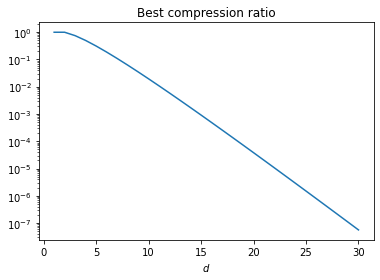

In [15]:
ds = np.arange(1,31)
bnd = 2*ds/2**ds

plt.figure()
plt.plot(ds, bnd)
plt.title("Best compression ratio")
plt.xlabel("$d$")
plt.yscale("log")

The 3 order Tensor $T_1[n_1,n_2,n_3]$ is approximated \textbf{"exactly"}  for TTrank $\ge 2$ (cited from section 3.1 at p. 4) by:

\begin{equation}\label{eq:T3}
    T_1[n_1,n_2,n_3] \approx \sum_{i=1,j=1,2}U_1[n_1,i]U_2[i,n_2,j]U_3[j,n3]
\end{equation}
This is not true as we see from the relative error in the Frobenius norm above. Only for TTrank = 4 the Tensor is \textit{"approximated exactly"} (rel err $\approx 10^{-15}$). 

Let's have a look at the matrices in the TTrain:
\begin{align*}
    U_1 &= \frac{1}{\sqrt{2}}
        \begin{pmatrix}
            -1 & 1
        \end{pmatrix} &
    U_2 &= \frac{1}{\sqrt{2}}
        \begin{pmatrix}
            -1 & 1 \\
             1 & 1
        \end{pmatrix}&
     U_3 &= \begin{pmatrix}
            * & \cdots & * \\
            * & \cdots & * 
            \end{pmatrix} \in \mathbb{R}^{2\times N_x/4}
\end{align*}


In [143]:
# calculate components of the Tensor
U1 = T1_TT.cores[0]
U2 = T1_TT.cores[1]
U3 = T1_TT.cores[2]

print("U_1 = ", U1.detach().cpu().numpy())
print("U_2 = ", U2.detach().cpu().numpy())

fnew = U3.detach().cpu().numpy()
for i in range(fnew.shape[0]):
    plt.plot(fnew[i,:])

plt.title("$U_3$")
plt.tick_params(labelbottom=False)
plt.xlabel("$x$")
plt.legend(("1. row","2. row"))
ap = U3.detach().cpu().numpy()


NameError: name 'T1_TT' is not defined

In [132]:
def QTT_f(f, order, threshold):
    arr = f.reshape([2]*order + [-1])
    t = torch.tensor(arr, dtype=torch.float64)
    tt = torchtt.TT(t, eps=threshold)
    return tt

def QTT_b(f, order, threshold):
    arr = f.reshape([-1] + [2]*order)
    t = torch.tensor(arr, dtype=torch.float64)
    tt = torchtt.TT(t, eps=threshold)
    return tt

def useless_ranks(tt):
    return []

nf1 = norm(f1)
for k in range(14):
    print("Modes:", k)
    ff = QTT_f(f1, k, 1e-5/np.sqrt(2*pi/N))
    print("Rank:", ff.R)
    ffarr = tt_to_numpy(ff).reshape(-1)
    print("Error:", norm(f1-ffarr)/nf1)
    print("Compression ratio:", tt_datasize(ff)/N)


Modes: 0
Rank: []
Error: 0.0
Compression ratio: 1.0001220703125
Modes: 1
Rank: [1]
Error: 0.00043937573465363663
Compression ratio: 0.500244140625
Modes: 2
Rank: [1, 2]
Error: 0.0004393757662544749
Compression ratio: 0.50048828125
Modes: 3
Rank: [1, 2, 4]
Error: 0.000439382421595768
Compression ratio: 0.50146484375
Modes: 4
Rank: [1, 2, 4, 5]
Error: 0.00044517692712969884
Compression ratio: 0.31640625
Modes: 5
Rank: [1, 2, 4, 5, 4]
Error: 0.0004503238812580842
Compression ratio: 0.13134765625
Modes: 6
Rank: [1, 2, 4, 5, 4, 3]
Error: 0.0004937126209054176
Compression ratio: 0.0546875
Modes: 7
Rank: [1, 2, 4, 5, 4, 3, 3]
Error: 0.000493718388301489
Compression ratio: 0.0323486328125
Modes: 8
Rank: [1, 2, 4, 5, 4, 3, 3, 2]
Error: 0.0006411746025764399
Compression ratio: 0.0174560546875
Modes: 9
Rank: [1, 2, 4, 5, 4, 3, 3, 2, 2]
Error: 0.0006411795733358915
Compression ratio: 0.0140380859375
Modes: 10
Rank: [1, 2, 4, 5, 4, 3, 3, 2, 2, 2]
Error: 0.000641179649754952
Compression ratio: 0.012

compression factor= 0.5008544921875
[2, 2]
relative error =  0.04121567033175619 %


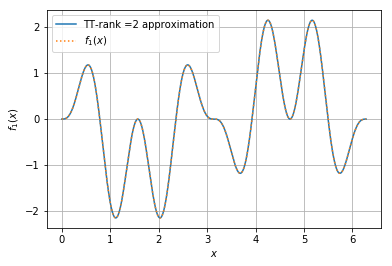

In [51]:
def plot_sinusoid(fun,TTrank=2,order=3):
    error, compress_factor, TTrain, fun_tilde, err_frob= TTapprox_fun(fun,order,TTrank,1e-14)
    plt.figure()
    plt.plot(x,fun_tilde,'-')
    plt.plot(x,fun,':')
    plt.legend(("TT-rank ="+str(max(TTrain.ranks()))+" approximation","$f_1(x)$"))
    plt.xlabel("$x$")
    plt.ylabel("$f_1(x)$")
    plt.grid()

    print("compression factor=",compress_factor)
    print(TTrain.ranks())
    print("relative error = ",error*100 ,"%")


plot_sinusoid(f1,2,3)


We now perform a parameter study of the order of the TTrain and the TTrank to see how storage and relative error behave. Suprisingly the order 2 Tensor with TT-rank 2 is already quite good.

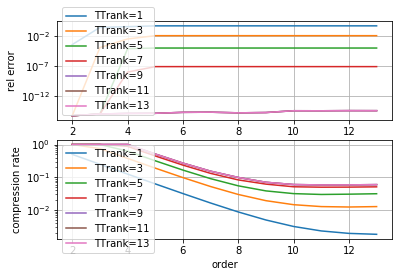

In [56]:
ord_list=range(2,14)
rank_list=range(1,15)

M = size(ord_list)
N = size(rank_list)
errors = zeros([M,N])
compress = zeros([M,N])
TTapprox_fun(f1,3,1, 1e-14)


for j,rank in enumerate(rank_list):
    for i,order in enumerate(ord_list):
        res = TTapprox_fun(f1,order,rank, 1e-14)
        errors[i,j]=res[0]
        compress[i,j]=res[1]

        
plt.figure()
plt.subplot(211)
for e,err in enumerate(errors.T[::2]):
    plt.semilogy(ord_list, err, label="TTrank=%d"%rank_list[2*e])
    
# plt.semilogy(ord_list,errors[:,0],'x--')
# plt.semilogy(ord_list,errors[:,1],'o-')
# plt.semilogy(ord_list,errors[:,3],':+')
# plt.plot(ord_list,errors[:,-1],':*')
plt.legend() # (['TTrank='+str(rank_list[0]),"TTrank="+str(rank_list[1]),"TTrank="+str(rank_list[3]),"TTrank="+str(rank_list[-1])])
plt.xlabel("order")
plt.ylabel("rel error")
plt.grid()

plt.subplot(212)

for e,cprs in enumerate(compress.T[::2]):
    plt.semilogy(ord_list, cprs, label="TTrank=%d"%rank_list[2*e])
    
# plt.plot(ord_list,compress[:,0],'x--')
# plt.plot(ord_list,compress[:,1],'o-')
# plt.plot(ord_list,compress[:,3],':+')
# plt.plot(ord_list,compress[:,-1],':*')
plt.legend()
plt.grid()
# plt.legend(['TTrank='+str(rank_list[0]),"TTrank="+str(rank_list[1]),"TTrank="+str(rank_list[3]),"TTrank="+str(rank_list[-1])])
plt.xlabel("order")
plt.ylabel("compression rate")
# plt.yscale("log")

plt.show()

### 2. Detection of self similar structures with noise

\begin{definition}[Self similar]\label{def:self_sim}
   $A$ is a self-similar set, if it is the invariant set (attractor) of an Iterated function system {$f_i, i=1\dots,m$}:
   
   \begin{align*}
     A={\bigcup _{i=1}^m} f_i(A)
    \end{align*}

\end{definition}


Construct a self similar function from $g(x)=$rect$(x-7)$:

\begin{equation}\label{eq:sel}
    f(x)=2000\sum_{k=0}^N\frac{g(x/(1.5)^k)}{(1.5)^k}
\end{equation}


Text(0.5,0,'x')

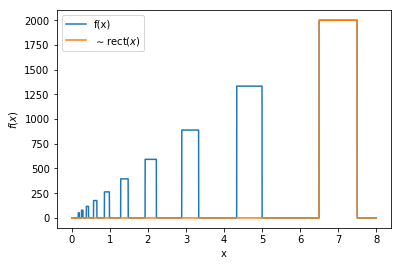

In [68]:
# Construct Data series
Nx= 2**14
x = linspace(0,8,Nx)

def rect(x):
    return heaviside(x-6.5,1)-heaviside(x-7.5,1)

data = 0*x
for k in range(0,10):
    data+=rect(x*1.5**k)/1.5**k

data*=2000

plt.plot(x,data)
plt.plot(x,2000*rect(x))
plt.legend(("f(x)",'$\sim$rect$(x)$'))
plt.ylabel("$f(x)$")
plt.xlabel("x")


Modulate a random noise on the data:


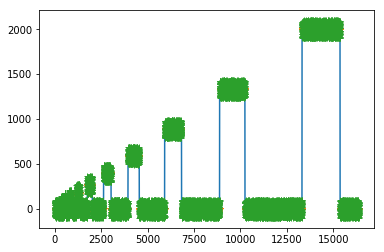

In [76]:
data1 = data + (1-2*np.random.rand(size(data)))
data10 = data + 100*(1-2*np.random.rand(size(data)))
plt.plot(data)
plt.plot(data1,"*")
plt.plot(data10,'+')

Text(0,0.5,'compression factor')

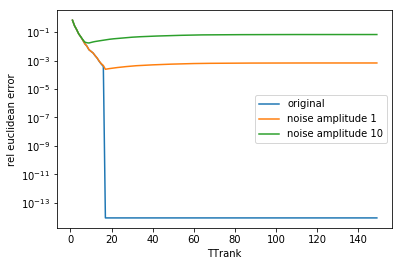

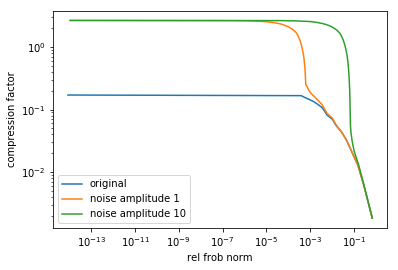

In [77]:
order=13
rank_list=range(1,150)
err_eucl=np.zeros([3,size(rank_list)])
compress=np.zeros([3,size(rank_list)])
err_frob=np.zeros([3,size(rank_list)])
ftilde=[]

for i,rank in enumerate(rank_list):
    
    # results for no noise
    res = TTapprox_fun(data,order,rank, 1e-14)
    err_eucl[0,i]=res[0]
    err_frob[0,i]=res[-1]
    compress[0,i]=res[1]
        
    # noise amplitude 1
    res = TTapprox_fun(data1,order,rank, 1e-14, data)  # self similarity --> noise is large in small strctures and cannot be cut off by HSVD
    err_eucl[1,i]=res[0]
    err_frob[1,i]=res[-1]
    compress[1,i]=res[1]
        
    #noise amplitude 10
    res = TTapprox_fun(data10,order,rank, 1e-14, data)
    err_eucl[2,i]=res[0]
    err_frob[2,i]=res[-1]
    compress[2,i]=res[1]
    
plt.semilogy(rank_list,err_eucl[0,:])
plt.semilogy(rank_list,err_eucl[1,:])
plt.semilogy(rank_list,err_eucl[2,:])
plt.xlabel("TTrank")
plt.ylabel("rel euclidean error")
plt.legend(["original","noise amplitude 1","noise amplitude 10"])

plt.figure()
for i in range(size(compress,0)):
    plt.loglog(err_frob[i,:],compress[i,:])
plt.legend(["original","noise amplitude 1","noise amplitude 10"])
plt.xlabel("rel frob norm")
plt.ylabel("compression factor")

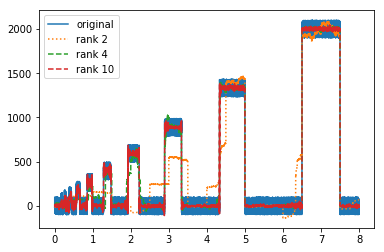

In [81]:
# plot results for TTrank=2 and 4

res = TTapprox_fun(data10,order,2, 1e-14)
plt.plot(x,data10)
plt.plot(x,res[3],':')
res = TTapprox_fun(data10,order,4, 1e-14)
plt.plot(x,res[3],'--')
res = TTapprox_fun(data10,order,10, 1e-14)
plt.plot(x,res[3],'--')
plt.legend(["original","rank 2","rank 4","rank 10"])


# References

(<a id="cit-LarK2017" href="#call-LarK2017">von Larcher and Klein, 2017</a>) von Larcher Thomas and Klein Rupert, ``_On identification of self-similar characteristics using the Tensor Train decomposition method with application to channel turbulence flow_'', arXiv preprint arXiv:1708.07780, vol. , number , pp. ,  2017.



@article{LarK2017,
  title={On identification of self-similar characteristics using the Tensor Train decomposition method with application to channel turbulence flow},
  author={von Larcher, Thomas and Klein, Rupert},
  journal={arXiv preprint arXiv:1708.07780},
  year={2017}
}